<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Feature_Engineering_Celeb_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from IPython.display import clear_output

In [2]:
!pip install scikit-learn
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
clear_output()

## Settings

In [3]:
base_dir = 'base_dir'
csv_attributes_path = 'csv_attributes_path'

__O Problema do Desbalanceamento Multilabel__

Em um cenário multilabel, cada amostra pode ter um ou mais rótulos (classes), o que significa que o modelo precisa lidar com a combinação de múltiplos rótulos ao mesmo tempo. Isso cria uma situação em que o desbalanceamento pode ocorrer em nível de classe individual (ou seja, algumas classes podem ser raras em todo o dataset), em nível de rótulo (onde uma amostra pode ter uma combinação específica de rótulos menos frequentes) ou em nível de instância (onde algumas amostras têm muitos rótulos enquanto outras têm apenas alguns).

Quando há um desbalanceamento significativo, o modelo pode tender a prever as classes mais frequentes corretamente, enquanto ignora as classes menos representadas, prejudicando a capacidade de generalização e levando a uma performance desigual.

__Veja abaixo o total de ocorrências de cada classe no dataset Celeb A completo__

## Loading the data

In [90]:
df = pd.read_csv(csv_attributes_path).replace(-1, 0)

Classe menos representada: Bald = 4547
Classe mais representada: No_Beard = 169158


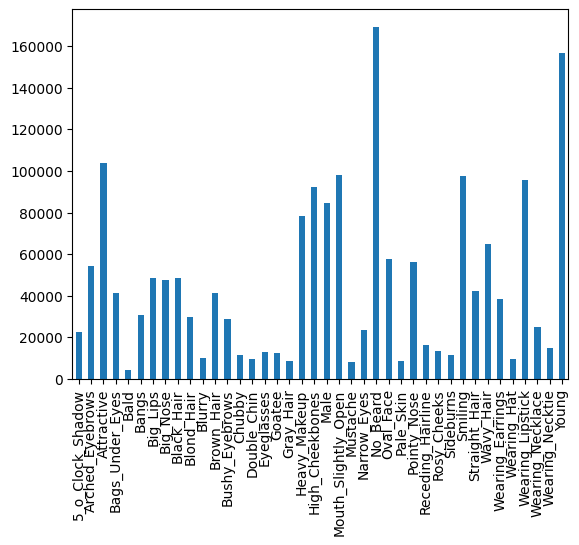

In [5]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Exploratory Data Analysis

A matriz de correlação é um excelente ponto de partida para esta análise. Já é possível encontrar nela pista de variáveis correlacionadas, que podem estar adicionando ruído ao modelo. Assim como, é possível encontrar indícios de classes que precisarão de data augmentation estratégico: __por exemplo, algumas características podem não estar presentes nos rostos femininos, mas é possível que mulheres as tenham.__

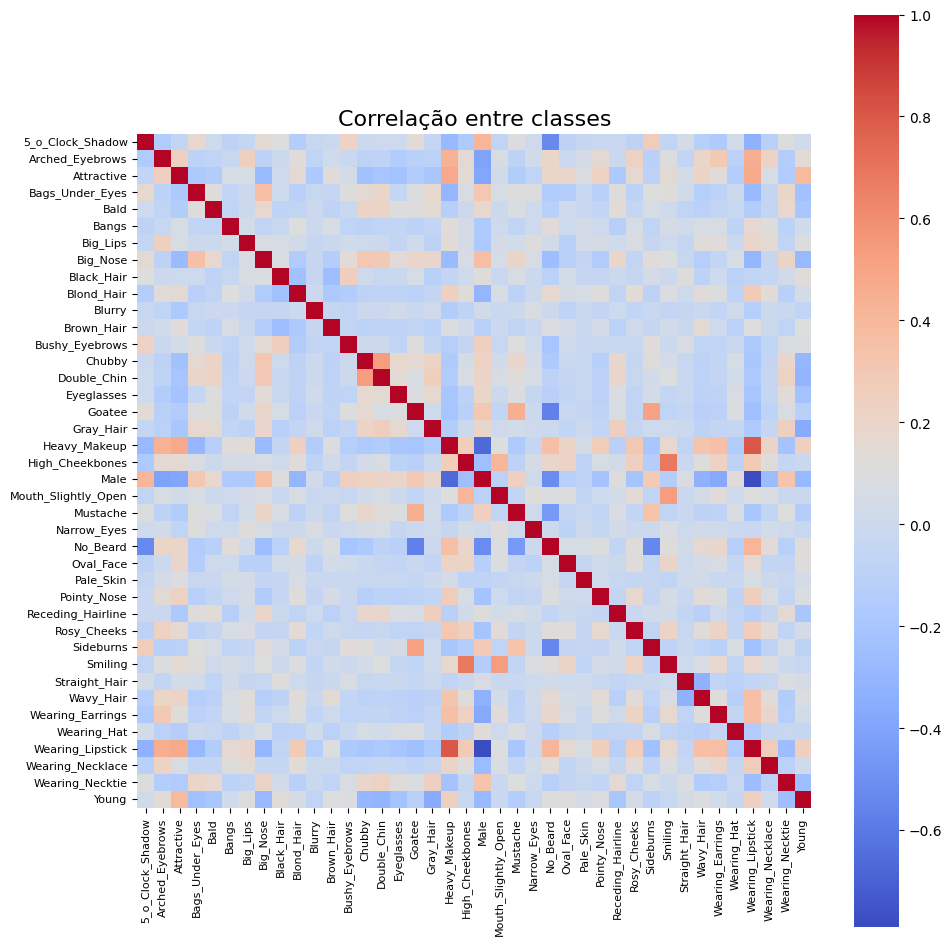

In [6]:
corr_matrix = df.iloc[:, 1:].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=True,
    cbar=True,
    square=True
)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.title("Correlação entre classes", fontsize=16)
plt.tight_layout()
plt.show()

Um clustering hierárquico pode ajudar a visualizar melhor essas relações. O número de clusters foi arbitrário.

---

Observe a classe Male e a quais rótulos ela está mais associada. Nesse dataset, geralmente homens possuem uma barba 5_o_clock_shadow, bolsões abaixo dos olhos (acúmulo de gordura), entradas, nariz grande, dentre outros. Com destaque para o cabelo cinza.

---

O cabelo cinza está fortemente associado a classe Male provavelmente por homens nem sempre pintarem os fios grisalhos. Ao analisar o dendograma a seguir, é possível perceber que ter fios cinzas é oposto a ser jovem. Logo, mulheres não jovens, que não possuem cabelo grisalho podem ser classificadas como jovens.

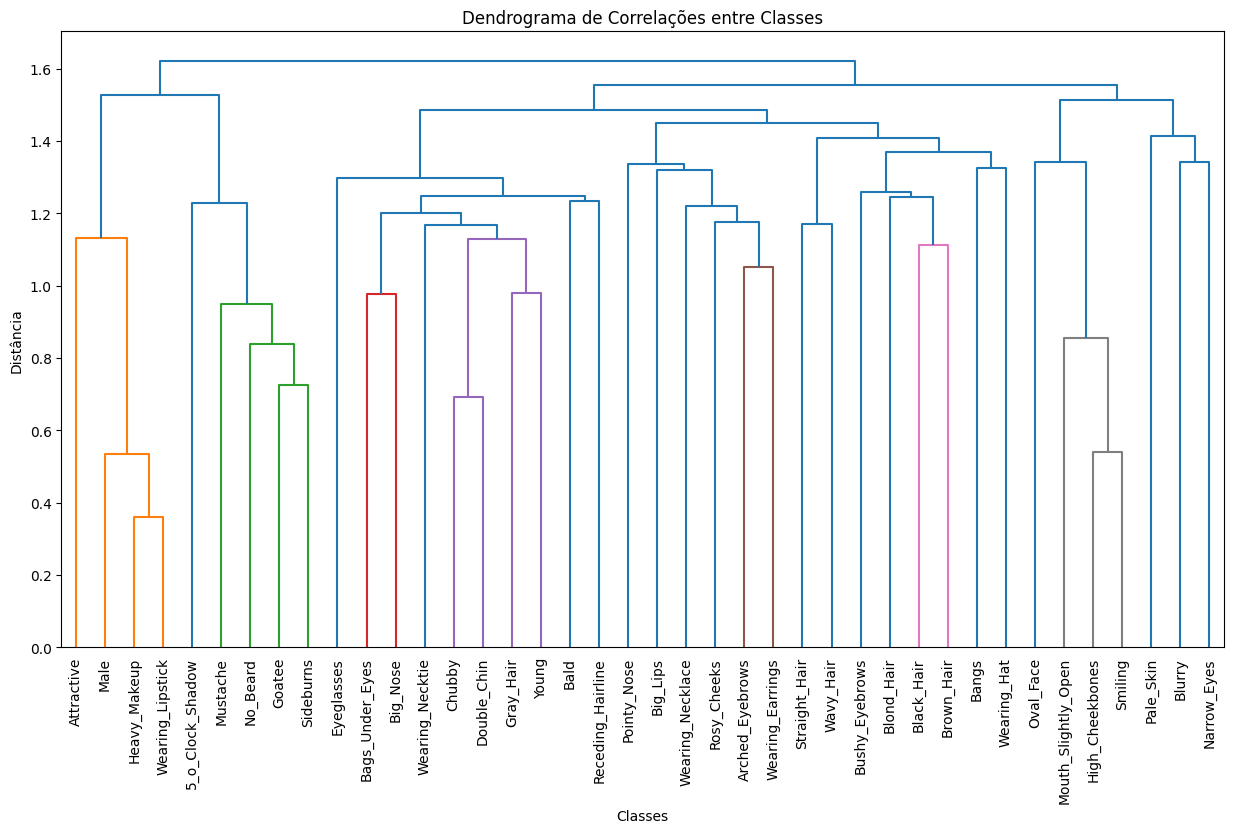

In [7]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


__Vamos analisar o dendogrma__

- O grupo laranja evidencia que a `atratividade` está opostamente associada ao gênero masculino, ao uso de batom e maquiagem forte. A atratividade é um conceito subjetivo, varia entre culturas, e talvez seja adequado retirá-lo.
    - heavy_makeaup e wearing_lipstick poderiam se tornar uma classe: wearing_makeup
- O grupo verde indica que estilos de barba, como costeletas, bigode, cavanhaque, são tidos indiretamente como 'tem barba'. Já 5_o_clock_shadow e mustache, estão acima nessa hierarquia. Essa relação parece meio confusa e é possível simplificar.
    - podemos excluir `no_beard`, e unificar atributos associados a barba como `facial_hair`
- Em relação a cores de cabelo, só pode ser loiro, preto, cinza ou castanho, um por vez. Parece estar ok essa hierarquia: se não é loiro, então é castanho ou preto. Já o cabelo cinza está associado a ser não jovem: se não tem cabelo cinza é jovem.

__Conclusão__

- Após esses ajustes, é importante observar quais características estão nas folhas do dendograma, o que pode indicar a necessidade de um ajuste fino nas imagens para que a rede diferencie melhor uma característica da outra. Ex.: Bangs e uso de chapéu parecem estar bem relacionados. Em um determinado ponto, a imagem será classificada em um dos atributos. Pode acontecer da rede confundir franja com chapéu e vice-versa.

- Entretanto, esses ajustes serão mais estratégicos após o treino da rede e inspeção das métricas de classificação.


## Some feature engineering

__Aplicando as modificações__

In [91]:
df['Wearing_Makeup'] = (df['Heavy_Makeup'] | df['Wearing_Lipstick']).astype(int)
df['Facial_Hair'] = (df['Sideburns'] | df['Mustache'] | df['Goatee'] | df['5_o_Clock_Shadow']).astype(int)
df = df.drop(
    columns=['Heavy_Makeup', 'Wearing_Lipstick', 'Sideburns', 'Mustache', 'Goatee', 'No_Beard', '5_o_Clock_Shadow', 'Attractive']
)

__Clusterizando novamente__

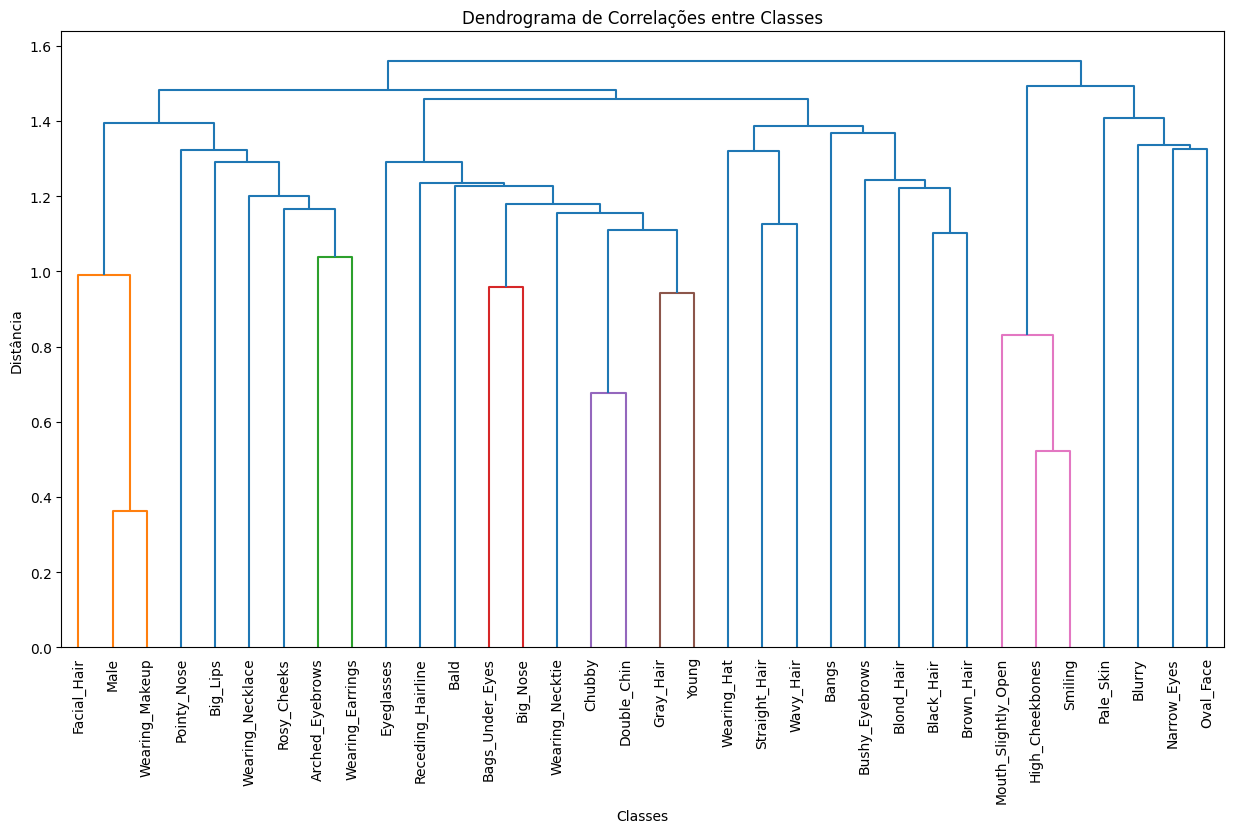

In [93]:
corr_matrix = df.iloc[:, 1:].corr()
clustering = AgglomerativeClustering(
    n_clusters=10,
    metric='precomputed',
    linkage='average'
)
distance_matrix = pdist(1 - abs(corr_matrix.values), metric='euclidean')
Z = linkage(distance_matrix, method='average')

plt.figure(figsize=(15, 8))
dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrograma de Correlações entre Classes")
plt.xlabel("Classes")
plt.ylabel("Distância")
plt.show()


Certamente, ainda existem ajustes a serem feitos, mas esse processo é iterativo e incremental. E as mudanças mais óbvias foram realizadas.

__Vamos ver a nova distribuição das 35 classes restantes__

- Observe que agora a classe mais representada é `Young`.

Classe menos representada: Bald = 4547
Classe mais representada: Young = 156734


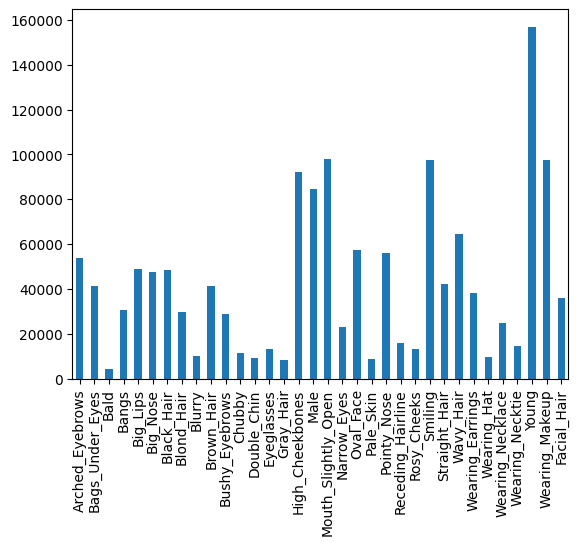

In [94]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Selecting the data

__Encontrando uma combinação de amostras equilibrada__

- A base é muito grande, e serão utilizadas no primeiro treino no máximo 3.500 imagens, 100 por classe, e sem data augmentation a princípio.

- O objetivo aqui é escolher aleatoriamente conjuntos de imagens que resulte em uma distribuição de classes mais equilibrada.

In [95]:
X = df.loc[:, 'image_id'].values.reshape(-1, 1)
y = df.iloc[:, 1:].values

In [96]:
import numpy as np
import random

def find_balanced_subset(X, y, num_iterations=100, per_class=100, seed=42):
    """
    Encontra um subconjunto balanceado de X e y que minimiza o desvio padrão relativo.

    :param X: Lista de nomes de arquivos (n_samples).
    :param y: Matriz binária indicando presença de classes (n_samples x num_classes).
    :param num_iterations: Número de iterações para encontrar o melhor conjunto.
    :param seed: Semente para reprodutibilidade.
    :return: Subconjunto X_best, y_best com o menor desvio padrão relativo.
    """
    np.random.seed(seed)
    random.seed(seed)

    def get_prob(y, std):
        y_ = y + np.sum(y, axis=0)
        y_ = np.std(y_, axis=1) / np.mean(y_, axis=1)
        p = std - y_
        p = 0.1 + (p - np.min(p)) / (np.max(p) - np.min(p)) * (1 - 0.1)
        p = p / np.sum(p)
        return p

    best_y_std_mean = np.std(np.sum(y, axis=0)) / np.mean(np.sum(y, axis=0))
    X_best, y_best = X, y
    p = get_prob(y_best, best_y_std_mean)
    print('std mean inicial:', best_y_std_mean)

    for i in range(num_iterations):
        num_samples, num_classes = y_best.shape
        selected_indices = []
        selected_indices.extend(
            np.random.choice(list(range(num_samples)), size=per_class * num_classes, replace=False, p=p)
        )

        selected_indices = np.sort(np.unique(selected_indices))
        y_sub = y[selected_indices]
        X_sub = [X[i] for i in selected_indices]

        y_sub_sum = np.sum(y_sub, axis=0)
        y_sub_std_mean = np.std(y_sub_sum) / np.mean(y_sub_sum)

        if y_sub_std_mean < best_y_std_mean:
            best_y_std_mean = y_sub_std_mean
            X_best, y_best = X_sub, y_sub
            p = get_prob(y_best, best_y_std_mean)
            print(best_y_std_mean)
        else:
            continue
    return X_best, y_best, best_y_std_mean

X_best, y_best, best_std_relative = find_balanced_subset(X, y, per_class=100, num_iterations=100000)

print(f"Melhor conjunto encontrado com desvio padrão relativo: {best_std_relative:.4f}")
print(f"Tamanho do novo conjunto: {len(X_best)} imagens")
print(f"Distribuição de classes no novo conjunto: {np.sum(y_best, axis=0)}")

std mean inicial: 0.7964289556882556
0.6806618538490502
Melhor conjunto encontrado com desvio padrão relativo: 0.6807
Tamanho do novo conjunto: 3400 imagens
Distribuição de classes no novo conjunto: [ 868  849  128  530  822  970  789  502  190  664  539  310  273  300
  252 1413 1639 1498  432  884  185  907  393  251 1478  743 1079  666
  202  442  357 2306 1446  722]


In [97]:
y_best.shape

(3400, 34)

In [103]:
np.unique(np.array(X_best).reshape(-1)).size

3400

In [102]:
df = df.loc[
    df.image_id.isin(np.array(X_best).reshape(-1)), :
]
df.to_csv(os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv'), index=False)

Classe menos representada: Bald = 128
Classe mais representada: Young = 2306


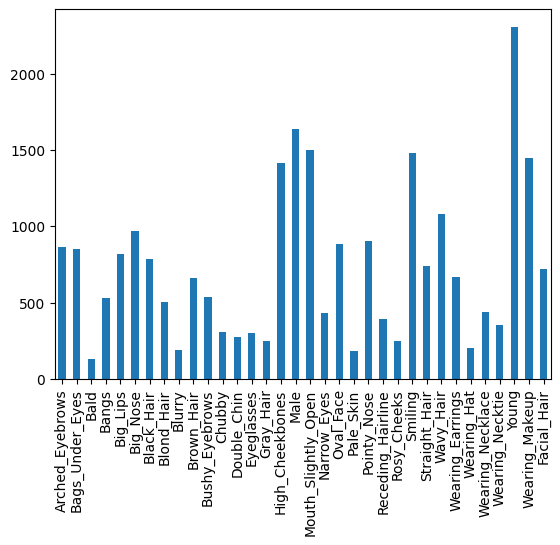

In [105]:
print(f'Classe menos representada: {df.columns[1:][df.iloc[:, 1:].sum().argmin()]} = {df.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {df.columns[1:][df.iloc[:, 1:].sum().argmax()]} = {df.iloc[:, 1:].sum().max()}')
df.iloc[:, 1:].sum().plot(kind='bar');

## Conclusão

1. A partir dessa análise inicial já é esperado que o modelo terá dificuldade em diferenciar faces jovens de não jovens. É esperado que mulheres sejam classificadas como jovem mais frequentemente do que deveria, pois a principal variável associada à idade é o cabelo grisalho, que é mais frequente em homens.

2. Também, outras características relacionadas à idade estão mais atreladas aos homens, como bolsas abaixo dos olhos, papada, e um rosto com aparência mais rechonchuda. Estas são características que mulheres também podem apresentar, então há boa chance de mulheres com essas características serem classificadas como homens.

3. Na configuração anterior, o modelo também poderia ter dificuldade em associar pelos faciais com o gênero. Com a unificação das variáveis em facial_hair, espera-se que a complexidade seja reduzida.

4. Por fim, a primeira versão do modelo deve ser treinada, e a partir da inspeção das métricas podemos avaliar qual ponto de melhoria mais significante. De qualquer forma, com essa análise sabemos o que esperar do modelo.